In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName('RDD Exercise') \
    .getOrCreate()
    
spark

In [4]:
houses = spark.read.csv('train.csv', header=True, inferSchema=True)

In [5]:
houses.toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62,7917,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85,13175,Pave,NA,Reg,Lvl,AllPub,...,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66,9042,Pave,NA,Reg,Lvl,AllPub,...,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68,9717,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2010,WD,Normal,142125


### 1. How many rows do not contains missing values in the LotFrontage, GarageYrBlt and MasVnrArea columns?

In [6]:
houses.filter(houses["LotFrontage"] != "NA") \
        .filter(houses["GarageYrBlt"] != "NA") \
        .filter(houses["MasVnrArea"] != "NA") \
        .count()

1121

### 2. What is the average houses price per each neighborhood?

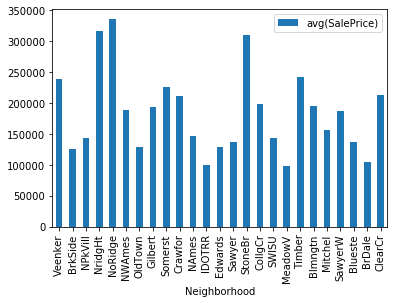

In [7]:
houses.select("Neighborhood", "SalePrice") \
        .groupBy("Neighborhood") \
        .avg() \
        .toPandas() \
        .plot \
        .bar(x='Neighborhood',y='avg(SalePrice)')

### 3. Which number of Bedrooms is more widely frequent?


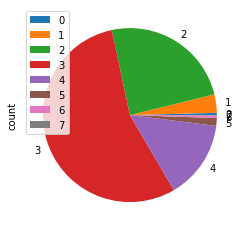

In [8]:
houses.groupBy("BedroomAbvGr").count().sort('BedroomAbvGr').toPandas().plot.pie(y='count')

### 4. What is distribusion of the dependent variable ?

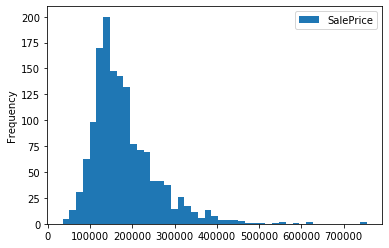

In [9]:
houses.select("SalePrice").toPandas().plot.hist(bins=45)

### 5. What is the correlation between SalePrice and the thought most relevant features?

In [10]:
from pyspark.mllib.stat import Statistics

In [11]:
relevant_features = ["OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF", "1stFlrSF", "FullBath", "TotRmsAbvGrd", "YearBuilt", "YearRemodAdd", "SalePrice"]
df = houses[relevant_features]

In [12]:
col_names = df.columns
features = df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")

In [13]:
import pandas as pd
corr_df = pd.DataFrame(corr_mat, 
                       columns=relevant_features,
                      index = relevant_features
                      )

In [14]:
corr_df["SalePrice"]

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
SalePrice       1.000000
Name: SalePrice, dtype: float64

### 6. Can we predict the House Price using the six most correlated features? Which model does perform better (Linear Regression & Decision Tree)? 

### 6.1 Linear Regression

In [15]:
df2 = houses["OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF", "1stFlrSF", "SalePrice"]

In [16]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF", "1stFlrSF"],
                            outputCol='features')
prep_houses = assembler.transform(df2)

In [17]:
prep_houses.toPandas()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,SalePrice,features
0,7,1710,2,548,856,856,208500,"[7.0, 1710.0, 2.0, 548.0, 856.0, 856.0]"
1,6,1262,2,460,1262,1262,181500,"[6.0, 1262.0, 2.0, 460.0, 1262.0, 1262.0]"
2,7,1786,2,608,920,920,223500,"[7.0, 1786.0, 2.0, 608.0, 920.0, 920.0]"
3,7,1717,3,642,756,961,140000,"[7.0, 1717.0, 3.0, 642.0, 756.0, 961.0]"
4,8,2198,3,836,1145,1145,250000,"[8.0, 2198.0, 3.0, 836.0, 1145.0, 1145.0]"
...,...,...,...,...,...,...,...,...
1455,6,1647,2,460,953,953,175000,"[6.0, 1647.0, 2.0, 460.0, 953.0, 953.0]"
1456,6,2073,2,500,1542,2073,210000,"[6.0, 2073.0, 2.0, 500.0, 1542.0, 2073.0]"
1457,7,2340,1,252,1152,1188,266500,"[7.0, 2340.0, 1.0, 252.0, 1152.0, 1188.0]"
1458,5,1078,1,240,1078,1078,142125,"[5.0, 1078.0, 1.0, 240.0, 1078.0, 1078.0]"


In [18]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
prep_houses = scaler.fit(prep_houses).transform(prep_houses)

In [19]:
from pyspark.ml.regression import LinearRegression

train, test = prep_houses.randomSplit([.7,.3], seed=10)
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='SalePrice')

lrModel = lr.fit(train)

trainingSummary = lrModel.summary

In [20]:
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 38596.777212
r2: 0.758094


In [21]:
lr_predictions = lrModel.transform(test)

In [22]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="SalePrice",metricName="rmse")

print("rmse of linear regression = %g" % lr_evaluator.evaluate(lr_predictions))

rmse of linear regression = 39511.1


### 6.2 Decision Tree Regressor 

In [23]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol='scaledFeatures', labelCol='SalePrice', maxDepth=7, minInstancesPerNode=3, maxBins=100)

model = dt.fit(train)

predictions = model.transform(test)
predictions.select("prediction", "SalePrice", "features").show(5)

evaluator = RegressionEvaluator(
    labelCol="SalePrice", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|103572.55102040817|    61000|[1.0,904.0,0.0,0....|
|44870.333333333336|    60000|[2.0,438.0,1.0,24...|
|103572.55102040817|    67000|[3.0,864.0,0.0,0....|
|103572.55102040817|    58500|[3.0,864.0,1.0,20...|
|103572.55102040817|    87500|[3.0,1040.0,2.0,4...|
+------------------+---------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 35822.4
